In [29]:
from onlineGreedyfile import onlineGreedy 
from onlinePrototypes import protonline
from onlineCriticism import crionline

import math
import scipy
import matplotlib.pyplot as plt 
%matplotlib inline

from sklearn.metrics.pairwise import rbf_kernel
import numpy as np
import matplotlib.pyplot as plt
from scipy import sparse 

import sys
import time

from kernelgenerator import compute_kernel

sys.path.insert(0, './src')
sys.path.insert(0, 'rff/ext')
import subsample, herding, rptree, rff

sys.path.insert(0, 'MMD')
from data import load_svmlight_file
from data import Data

In [30]:
# Download and read MNIST data
import input_data
mnist = input_data.read_data_sets('rff/ext/MNIST')
M = 50
N = 50000
stream = mnist.train.images[:N]

Extracting rff/ext/MNIST/train-images-idx3-ubyte.gz
Extracting rff/ext/MNIST/train-labels-idx1-ubyte.gz
Extracting rff/ext/MNIST/t10k-images-idx3-ubyte.gz
Extracting rff/ext/MNIST/t10k-labels-idx1-ubyte.gz


In [31]:
class SyntheticTarget(object):
    
    def __init__(self, dist_components=2, dim=2, seed=None):
        if seed is not None:
            np.random.seed(seed)
        self.dist_weights = stats.dirichlet(np.ones(dist_components)*10).rvs().ravel()
        dist_centers = np.random.uniform(-4, 4, size=(dist_components, dim))

        def gen_cov():
            assert(dim == 2)
            rho = np.random.rand()-0.5
            sd = np.random.rand(dim)*0.4+0.5
            L = np.zeros((dim,dim))
            L[0,0] = sd[0]**2
            L[1,1] = sd[1]**2
            L[0,1] = rho*sd.prod()
            return np.dot(L, L.T)

        dist_cov = np.array([gen_cov() for i in xrange(dist_components)])
        self.dist_obj = np.array([stats.multivariate_normal(dist_centers[k], dist_cov[k]) for k in xrange(dist_components)], dtype=object)
        self.dim = dim

    def compute_pdf(self, x):
        return np.sum(self.dist_weights[:,None,None] * np.array([d.pdf(x) for d in self.dist_obj]), 0)

    def draw_sample(self, ns=1):
        component = np.random.multinomial(ns, self.dist_weights) # np.argmin(np.random.rand() > self.dist_weights.cumsum())
        offset = np.concatenate(([0], component.cumsum()[:-1]))
        samples = np.empty((ns,self.dim))
        for c, n in enumerate(component):
            if n > 0:
                samples[offset[c]:offset[c]+n] = self.dist_obj[c].rvs(n) 
        np.random.shuffle(samples)
        return samples

    def draw_sample_slow(self):
        component = np.argmin(np.random.rand() > self.dist_weights.cumsum())
        return self.dist_obj[component].rvs()

    def plot(self):
        delta = 0.1
        boundary = 5
        x = np.arange(-boundary, boundary, delta)
        y = np.arange(-boundary, boundary, delta)
        X, Y = np.meshgrid(x, y)
        Z = np.log(self.compute_pdf(np.concatenate((X[:,:,None],Y[:,:,None]),2)))
        plt.figure()
        contour_levels = np.arange(-9,1)
        CS = plt.contour(X, Y, Z, levels=contour_levels)
        plt.set_cmap('Blues')
        

In [32]:
from __future__ import division  #So that when we divide by integers we gegt a float. Eg so that 5/2 = 2.5 not 2.
import numpy as np


def online_loss_reg_max(stream, gamma, new_phi, phis_for_criticisms, full_phi_sum, proto_phi_sum, prototype_indices, criticism_indices, n, M, full_stream_phi, N):
    #ONLINE_LOSS_MAX maximizes L(C) online.
    #Here we are adding x_n and assume that stored_phis and full_phi_sum have been updated to include x_new: the new data point.
    
    criticism_indices = np.hstack((criticism_indices,n-1))
    criticism_kernel_matrix = compute_kernel(stream[criticism_indices], M+1, gamma)
    phis_for_criticisms = np.vstack((phis_for_criticisms,new_phi))
    #print phis_for_criticisms.shape
    
    losses = np.zeros(M+1)
    overall_losses = np.zeros(M+1)
    for l in range(M+1):
        #losses[l] = np.abs((1/n)*sum(kernel_matrix[range(n),criticism_indices[l]]) - (1/M)*sum(kernel_matrix[prototype_indices,criticism_indices[l]]))
        #overall_losses[l] = np.abs((1/N)*sum(kernel_matrix[range(N), criticism_indices[l]]) - (1/M)*sum(kernel_matrix[true_proto_indices, criticism_indices[l]]))
        losses[l] = np.abs((1/n)*np.inner(full_phi_sum, phis_for_criticisms[l,:]) - (1/M)*np.inner(proto_phi_sum, phis_for_criticisms[l,:]))
        #overall_losses[l] = np.abs((1/N)*np.inner(full_stream_phi, phis_for_criticisms[l,:]) - (1/M)*np.inner(proto_phi_sum, phis_for_criticisms[l,:]))
    
    total_loss = sum(losses)
    F = np.zeros(M+1)
    for y in range(M+1):
        #print criticism_kernel_matrix
        mate = criticism_kernel_matrix[np.setdiff1d(range(M+1), y), :][:, np.setdiff1d(range(M+1), y)]
        #print mate.shape
        r = np.log(np.linalg.det(criticism_kernel_matrix[np.setdiff1d(range(M+1), y), :][:, np.setdiff1d(range(M+1), y)]))
        F[y] = total_loss - losses[y] + r
    #print(sum(overall_losses))
    
    idx_to_exclude = np.argmax(F)
    #print F[idx_to_exclude]
    criticism_indices = np.delete(criticism_indices, idx_to_exclude)
    phis_for_criticisms = np.delete(phis_for_criticisms, idx_to_exclude, axis=0)
    
    #print(losses)
    #min_loss_idx = np.argmin(losses)
    #min_loss_idx = np.argmin(overall_losses)
    #min_loss = losses[min_loss_idx]
    #new_loss = losses[M]
    #print(min_loss_idx)
    #print(sum(overall_losses))
    #print(sum(losses))

    #if new_F > min_F:
        #print(criticism_indices)
        #criticism_indices = np.delete(criticism_indices, min_F_idx)
        #phis_for_criticisms = np.delete(phis_for_criticisms, (min_F_idx), axis=0)
        #print phis_for_criticisms.shape
        
    #else:
        #criticism_indices = np.delete(criticism_indices, M)
        #phis_for_criticisms = np.delete(phis_for_criticisms, (M), axis=0)
        #print phis_for_criticisms.shape
        
    olm_return = [criticism_indices, phis_for_criticisms]
    return olm_return

In [13]:
#The below generates the function to calculate phi_hat, median_heuristic calcuates a value for gamma.
gamma = rff.median_heuristic(stream[:M])
phi = rff.RFF(500, 784, lengthscale=gamma) 

#kernel_matrix = compute_kernel(stream, N, gamma = 0.029)

#Initialization:
prototype_points = np.array(stream[:M])
criticism_indices = range(M, 2*M)
phis_for_criticisms = phi(np.array(stream[criticism_indices]))

# Compute batch benchmark feature mean
#full_stream_phi = phi(stream).mean(0)
#full_stream_sq_norm = np.sum(full_stream_phi**2,0)

subsampler = subsample.LinearSubsampler(prototype_points, phi, logging=True)
full_stream_phi = sum(phi(stream))

#for i in xrange(2*M, len(stream)):
for i in range(2*M, N):
    if np.mod(i, 500) == 1:
        print i-1
    subsampler.consider(stream[i])
    prototype_indices = subsampler.which
    is_accepted = subsampler.accepted[-1]
    #print (i+1)*subsampler._full_mean_phi
    #print subsampler.total_sum_test
    
    #prototype_indices = np.asarray([5520, 9233, 8410, 2765 ,5408, 7700 ,6251 ,3124, 3154 ,8664])
    
    if not is_accepted:
        olm_return = online_loss_reg_max(new_phi = phi(stream[i]), phis_for_criticisms = phis_for_criticisms, 
                                         full_phi_sum = subsampler.total_sum_test, 
                                         proto_phi_sum = subsampler.sample_sum_test, 
                                         prototype_indices = prototype_indices, 
                                         criticism_indices = criticism_indices, n = i+1, 
                                         M = M, full_stream_phi = full_stream_phi, N = N,
                                         stream = stream, gamma = 0.029)
                                         #kernel_matrix = kernel_matrix)
                                         #true_proto_indices = np.asarray([912, 755, 576, 919 ,962, 902 ,775 ,850 ,906, 948]))
        criticism_indices = olm_return[0]
        #print criticism_indices
        #print criticism_indices
        phis_for_criticisms = olm_return[1]

500
1000
1500
2000
2500
3000
3500
4000
4500
5000
5500
6000
6500
7000
7500
8000
8500
9000
9500
10000
10500
11000
11500
12000
12500
13000
13500
14000
14500
15000
15500
16000
16500
17000
17500
18000
18500
19000
19500
20000
20500
21000
21500
22000
22500
23000
23500
24000
24500
25000
25500
26000
26500
27000
27500
28000
28500
29000
29500
30000
30500
31000
31500
32000
32500
33000
33500
34000
34500
35000
35500
36000
36500
37000
37500
38000
38500
39000
39500
40000
40500
41000
41500
42000
42500
43000
43500
44000
44500
45000
45500
46000
46500
47000
47500
48000
48500
49000
49500


In [ ]:
#resultImages = online_loss_reg_max(stream, gamma, new_phi, phis_for_criticisms, 
#                                   full_phi_sum, proto_phi_sum, prototype_indices, 
#                                   criticism_indices, n, M, full_stream_phi, N):

In [26]:
print criticism_indices
print prototype_indices
data = stream
#data[criticism_indices][1]

[ 3104  4985  6133  8179  8650 11676 11909 12592 17698 18000 18938 24048
 28522 29202 35492 36054 37934 42650 46415 47830]
[ 1357  1276  1136 43155 22365   315   676 19358 32864 15071 34486 37273
   829  7156 24264   320    16  5130  5982   113]


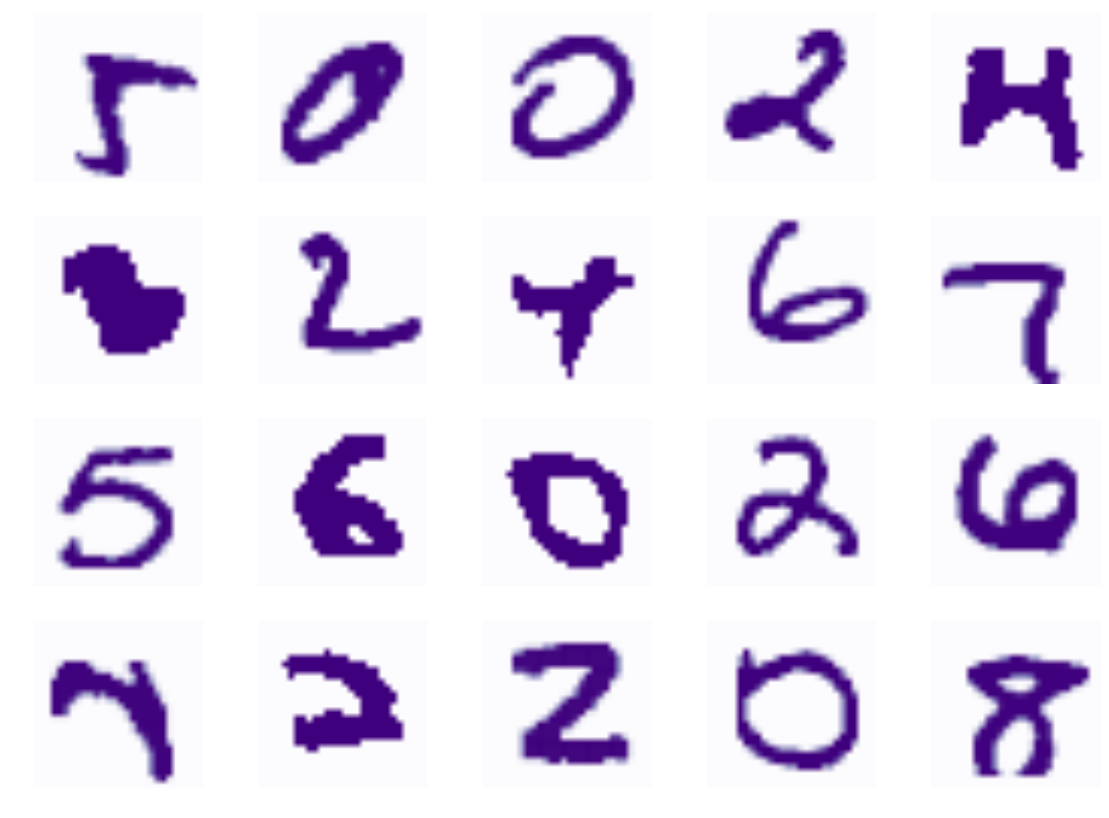

In [28]:
#plotting the criticism
plt.figure(figsize=(14,10))
for i in xrange(20):
    plt.subplot(20/5,5,i+1)
    plt.imshow(data[criticism_indices][i].reshape((28,28)))
    plt.axis('off')
    #plt.title(mnist.train.labels[i])
    plt.set_cmap('Purples')